In [7]:
df = pd.read_csv('shop2_resto.csv',encoding='latin1')

In [8]:
from xgboost import XGBRegressor

In [9]:
df.columns

Index(['month_idx', 'hour_idx', 'mday_idx', 'year_idx', 'temperature',
       'precipitation', 'snowfraction', 'sealevelpressure', 'winddirection',
       'windspeed', 'relativehumidity', 'sunshinetime', 'totalcloudcover',
       'lowclouds', 'midclouds', 'highclouds', 'wday_x', 'month', 'hour',
       'mday', 'year', 'timestamp', 'is_resto', 'month.1', 'hour.1', 'mday.1',
       'year.1', 'price', 'count', 'n_transactions', 'last_week_price',
       'last_month_price'],
      dtype='object')

In [53]:
features = ['precipitation', 'snowfraction', 'sealevelpressure', 'winddirection',
       'windspeed', 'relativehumidity', 'sunshinetime', 'totalcloudcover',
       'lowclouds', 'midclouds', 'highclouds','last_week_price','last_month_price', 
         'mday', 'hour', 'wday_x'] 
X = df[ features ]
y = df['price']

In [14]:
?XGBRegressor

In [37]:
reg  = XGBRegressor(max_depth=10,n_estimators=300,subsample=0.8, base_score=y.mean(), random_state=1234)

In [38]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2345)

In [46]:
reg.fit(X_train,y_train)

XGBRegressor(base_score=390.1651928081383, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [47]:
reg.score(X_test,y_test)

0.808674316895875

In [48]:
y_pred = reg.predict(X_test)

In [49]:
from sklearn.metrics import r2_score

In [50]:
r2_score(y_test,y_pred)

0.808674316895875

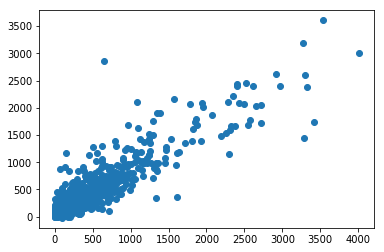

In [51]:
plt.scatter(y_test,y_pred)

In [55]:
list(zip(features, reg.feature_importances_))

[('precipitation', 0.041224755),
 ('snowfraction', 0.0012117263),
 ('sealevelpressure', 0.18071662),
 ('winddirection', 0.13917916),
 ('windspeed', 0.12910749),
 ('relativehumidity', 0.088521175),
 ('sunshinetime', 0.03903583),
 ('totalcloudcover', 0.027218241),
 ('lowclouds', 0.023400651),
 ('midclouds', 0.026436482),
 ('highclouds', 0.042332247),
 ('last_week_price', 0.12294462),
 ('last_month_price', 0.0),
 ('mday', 0.045446254),
 ('hour', 0.065641694),
 ('wday_x', 0.027583063)]